#Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img


def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


def vgg_layers(layer_name):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_name]
    model = tf.keras.Model([vgg.input], outputs)
    return model


def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/num_locations


def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                          for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                            for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss


def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]
  return x_var, y_var


def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))


@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor, 'RGB')


class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                            for style_output in style_outputs]

        content_dict = {content_name:value
                         for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value
                      for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

# Run

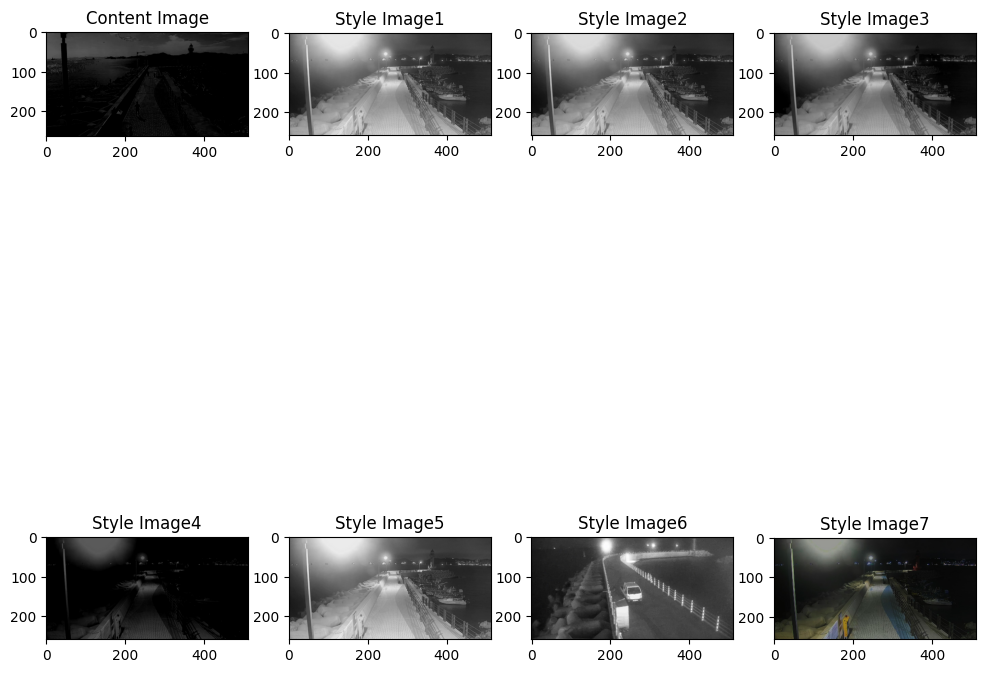

In [ ]:
# content_image = load_img('/content/주간cctv3.jpg')
#content_image = load_img('/content/blur.jpg')
content_image = load_img('/content/endplz(100,100)(cv150,5,5).jpg')

style_image1 = load_img('/content/drive/MyDrive/DSBA_예비프로젝트/추석/흑백처리/26blbkgd(cv10,11_11).jpg')
style_image2 = load_img('/content/drive/MyDrive/DSBA_예비프로젝트/추석/흑백처리/26blbkgd(cv20,11_11).jpg')
style_image3 = load_img('/content/drive/MyDrive/DSBA_예비프로젝트/추석/흑백처리/26blbkgd(cv40,15_15).jpg')
style_image4 = load_img('/content/drive/MyDrive/DSBA_예비프로젝트/추석/흑백처리/CCTV3bgrd(cv150,9_9).jpg')
style_image5 = load_img('/content/drive/MyDrive/DSBA_예비프로젝트/추석/흑백처리/CCTV3bgrd(cv5,9_9).jpg')
style_image6 = load_img('/content/drive/MyDrive/DSBA_예비프로젝트/추석/흑백처리/jtestbackground2.jpg')
style_image7 = load_img('/content/drive/MyDrive/DSBA_예비프로젝트/추석/흑백처리/plzbackg.jpg')


plt.subplot(2,4,1)
imshow(content_image, 'Content Image')


plt.subplot(2,4,2)
imshow(style_image1, 'Style Image1')

plt.subplot(2,4,3)
imshow(style_image2, 'Style Image2')

plt.subplot(2,4,4)
imshow(style_image3, 'Style Image3')

plt.subplot(2,4,5)
imshow(style_image4, 'Style Image4')

plt.subplot(2,4,6)
imshow(style_image5, 'Style Image5')

plt.subplot(2,4,7)
imshow(style_image6, 'Style Image6')

plt.subplot(2,4,8)
imshow(style_image7, 'Style Image7')


In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image6*255)

extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

style_targets = extractor(style_image6)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
    #기본값 1e-2
content_weight=1e4  #기본값 1e4

total_variation_loss(image).numpy()
total_variation_weight=30

image = tf.Variable(content_image)
start = time.time()
epochs = 300
steps_per_epoch = 100

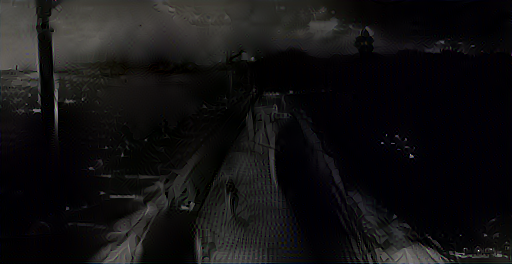

299/300
training time : 1617.3


In [ ]:
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        train_step(image)
        print(".", end="")
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f'{epoch}/{epochs}')

print(f'training time : {time.time() - start:.1f}')

In [ ]:
results = tensor_to_image(image)
#results.save('result_testblur(26back,cv70,1e-4,1e7).jpg')
#results.save('result_testblur(backgr,cv70,1e-4,1e7).jpg')
results.save('endplz(100,100)(cv150,5,5)st6(ep300,1e-2,1e4)1.jpg')

In [ ]:
 '''
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        train_step(image)

results = tensor_to_image(image)
'''